## 0. Load datasets

In [38]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from measurements import get_prev_or_next_frame
from sklearn import preprocessing, model_selection, feature_selection, metrics, inspection, pipeline

from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

%matplotlib widget

In [39]:
dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
basals = pd.read_pickle(path.join(dataset_dir,f'basals.pkl'))
division_12h = pd.read_pickle(path.join(dataset_dir,f'divisions_12h.pkl'))

# censor the 'answers'
features2drop = [(f,a) for f,a in division_12h.columns if 'Time' in f]
features2drop += [(f,a) for f,a in division_12h.columns if 'Manual' in f]
features2drop += [(f,a) for f,a in division_12h.columns if 'duration' in f]
features2drop += [(f,a) for f,a in division_12h.columns if 'Total' in f]
features2drop += [(f,a) for f,a in division_12h.columns if 'cell coords' in f]
features2drop += [(f,a) for f,a in division_12h.columns if 'smoothed' in f and not 'rate' in f]
features2drop += [(f,a) for f,a in division_12h.columns if 'exponential' in f and not 'G1 only' in f]
features2drop += ['Z','Z-cyto']
division_12h = division_12h[~np.isnan(division_12h['Num daughter differentiated','Meta'])]
division_12h = division_12h.drop(features2drop,axis=1)
print(len(division_12h))

241


/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_91049/2546565649.py:16: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  division_12h = division_12h.drop(features2drop,axis=1)


In [40]:
# Grouped Standard Scaler
class GroupedStandardScaler(BaseEstimator, TransformerMixin):
    """
    Standardize features by removing the mean and scaling to unit variance,
    computed separately for each group defined by a categorical variable.
    
    Parameters
    ----------
    group_col : str
        Name of the categorical column to group by for standardization
    
    with_mean : bool, default=True
        If True, center the data before scaling
    
    with_std : bool, default=True
        If True, scale the data to unit variance
    
    Attributes
    ----------
    group_means_ : dict
        Dictionary mapping group values to mean arrays
    
    group_stds_ : dict
        Dictionary mapping group values to standard deviation arrays
    
    feature_names_ : list
        List of feature column names (excluding group_col)
    
    groups_ : array
        Unique group values seen during fit
    """
    
    def __init__(self, group_col, with_mean=True, with_std=True):
        self.group_col = group_col
        self.with_mean = with_mean
        self.with_std = with_std
    
    def fit(self, X, y=None):
        """
        Compute the mean and std to be used for later scaling, per group.
        
        Parameters
        ----------
        X : pandas DataFrame of shape (n_samples, n_features)
            The data used to compute the per-group means and standard deviations
            used for later scaling along the features axis.
        
        y : None
            Ignored
        
        Returns
        -------
        self : object
            Fitted scaler
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a pandas DataFrame")
        
        if self.group_col not in X.columns:
            raise ValueError(f"group_col '{self.group_col}' not found in DataFrame")
        
        # Store feature names (excluding group column)
        self.feature_names_ = [col for col in X.columns if col != self.group_col]
        
        # Use groupby for vectorized computation
        grouped = X.groupby(self.group_col)[self.feature_names_]
        
        if self.with_mean:
            self.group_means_ = grouped.mean()
        else:
            self.group_means_ = pd.DataFrame(
                0, 
                index=grouped.groups.keys(), 
                columns=self.feature_names_
            )
        
        if self.with_std:
            self.group_stds_ = grouped.std()
            # Replace zero std with 1 to avoid division by zero
            self.group_stds_ = self.group_stds_.replace(0, 1.0)
        else:
            self.group_stds_ = pd.DataFrame(
                1.0, 
                index=grouped.groups.keys(), 
                columns=self.feature_names_
            )
        
        return self
    
    def transform(self, X):
        """
        Perform standardization by centering and scaling per group.
        
        Parameters
        ----------
        X : pandas DataFrame of shape (n_samples, n_features)
            The data to transform
        
        Returns
        -------
        X_transformed : pandas DataFrame of shape (n_samples, n_features)
            Transformed DataFrame
        """
        check_is_fitted(self, ['group_means_', 'group_stds_', 'feature_names_'])
        
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a pandas DataFrame")
        
        if self.group_col not in X.columns:
            raise ValueError(f"group_col '{self.group_col}' not found in DataFrame")
        
        # Create a copy to avoid modifying original
        X_transformed = X.copy()
        
        # Align means and stds with X using merge (much faster than map)
        means_aligned = X[[self.group_col]].join(
            self.group_means_, on=self.group_col, how='left'
        )
        stds_aligned = X[[self.group_col]].join(
            self.group_stds_, on=self.group_col, how='left'
        )
        
        # Vectorized standardization
        X_transformed[self.feature_names_] = (
            X[self.feature_names_].values - means_aligned[self.feature_names_].values
        ) / stds_aligned[self.feature_names_].values
        
        # Check for unseen groups (NaN values after join)
        if means_aligned[self.feature_names_].isna().any().any():
            unseen_groups = X.loc[means_aligned[self.feature_names_].isna().any(axis=1), self.group_col].unique()
            import warnings
            warnings.warn(f"Found unseen groups during transform: {unseen_groups}. These samples will not be standardized.")
            # Keep original values for unseen groups (where NaN resulted)
            nan_mask = means_aligned[self.feature_names_].isna().any(axis=1)
            X_transformed.loc[nan_mask, self.feature_names_] = X.loc[nan_mask, self.feature_names_]
        
        return X_transformed.drop(columns=self.group_col)
    
    def fit_transform(self, X, y=None):
        """
        Fit to data, then transform it.
        
        Parameters
        ----------
        X : pandas DataFrame of shape (n_samples, n_features)
            Input data
        
        y : None
            Ignored
        
        Returns
        -------
        X_transformed : pandas DataFrame of shape (n_samples, n_features)
            Transformed DataFrame
        """
        return self.fit(X, y).transform(X)
    
    def inverse_transform(self, X):
        """
        Scale back the data to the original representation per group.
        
        Parameters
        ----------
        X : pandas DataFrame of shape (n_samples, n_features)
            The data to inverse transform
        
        Returns
        -------
        X_original : pandas DataFrame of shape (n_samples, n_features)
            DataFrame in original scale
        """
        check_is_fitted(self, ['group_means_', 'group_stds_', 'feature_names_'])
        
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a pandas DataFrame")
        
        if self.group_col not in X.columns:
            raise ValueError(f"group_col '{self.group_col}' not found in DataFrame")
        
        # Create a copy
        X_original = X.copy()
        
        # Align means and stds with X using merge
        means_aligned = X[[self.group_col]].join(
            self.group_means_, on=self.group_col, how='left'
        )
        stds_aligned = X[[self.group_col]].join(
            self.group_stds_, on=self.group_col, how='left'
        )
        
        # Vectorized inverse transformation
        X_original[self.feature_names_] = (
            X[self.feature_names_].values * stds_aligned[self.feature_names_].values
        ) + means_aligned[self.feature_names_].values
        
        return X_original
        


In [41]:
# Helper functions
def get_balanced_df_by_category(df,category,subsample=None,replacement=True):
    # assert(logical.dtype == bool)
    
    # Find the category with least members
    categories = {cat:mem for cat, mem in df.groupby(category)}
    num_per_category = np.array([len(mem) for mem in categories.values()])
    smallest_category = list(categories.keys())[num_per_category.argmin()]

    num_to_sample = min(subsample if subsample is not None else num_per_category.min(), num_per_category.min())
    
    output = []
    for cat, member in categories.items():
        if cat == smallest_category:
            output.append(member.sample(num_to_sample,replace=replacement))
        else:
            output.append(member.sample(num_to_sample,replace=replacement))
    output = pd.concat(output,ignore_index=True)
    
    return output

def predict_feature(df:pd.DataFrame,
                    classifier,
                    feature2predict,
                    groupby_name = 'Region',
                    Niter:int=100,
                    model_params = {},
                    measurement_level_name:str='Measurement'):
    training_set = []
    Y_test = []
    Y_pred = []
    models = []
    for i in tqdm(range(Niter)):

        # rng = np.random.RandomState(0)
        df_ = get_balanced_df_by_category(df, df[feature2predict,'Meta'].values)
        
        pipe = pipeline.make_pipeline(GroupedStandardScaler('Region'),
                                      classifier(random_state=i,**model_params) )
        
        y = df_[feature2predict,'Meta'].astype(float)
        X = df_.xs(measurement_level_name,level=1,axis=1).astype(float)
        X[np.isinf(X)] = np.nan
        X['Region'] = df_['Region']
        X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,random_state=i+1)
        
        model = pipe.fit(X_train,y_train)
        models.append(model)
        
        Y_test.append(y_test)
        Y_pred.append(model.predict(X_test))

        training_set.append((X_train,y_train,X_test,y_test))
        
    return [np.stack((np.array(Y_test),np.array(Y_pred))),models,training_set]
    

In [35]:
lineages = {linID:lineage for linID,lineage in basals.droplevel(axis=1,level=1).groupby('LineageID')}
lineage_length = pd.Series({linID:len(lineage) for linID,lineage in lineages.items()})
lineage_length.sort_values().tail()
# all_df[all_df['LineageID','Meta'] == 195]

195.0    61
90.0     63
169.0    70
234.0    70
248.0    70
dtype: int64

## 1. Predict from mother division frame

In [42]:
feature2predict = 'At least one daughter differentiated'
division_12h.droplevel(axis=1,level=1).groupby(feature2predict).count()

Name,Nuclear volume,Nuclear solidity,Y,X,Nuclear height,Cell volume,Y-cyto,X-cyto,Axial component,Planar component 1,...,Std adjac Mean curvature 10um at 1 frame prior,Max adjac cyto_shcoeffs_L1M1C at 1 frame prior,Min adjac cyto_shcoeffs_L1M1S at 1 frame prior,Median adjac Apical area at 1 frame prior,Std adjac Axial angle at 1 frame prior,Num neighbor division 1 frame prior,Num neighbor delamination 1 frame prior,Num daughter differentiated,Both daughters differentiated,Region
At least one daughter differentiated,,,,,,,,,,,,,,,,,,,,,
False,55,55,55,55,55,55,55,55,55,55,...,48,48,48,48,48,48,48,55,55,55
True,186,186,186,186,186,186,186,186,186,186,...,158,158,158,158,158,158,158,186,186,186


In [45]:
# Run classifier
# axis0: observation axis1: prediction

predictions,models,training_set = predict_feature(division_12h,
                                     ensemble.RandomForestClassifier, feature2predict,Niter=100)


100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.98it/s]


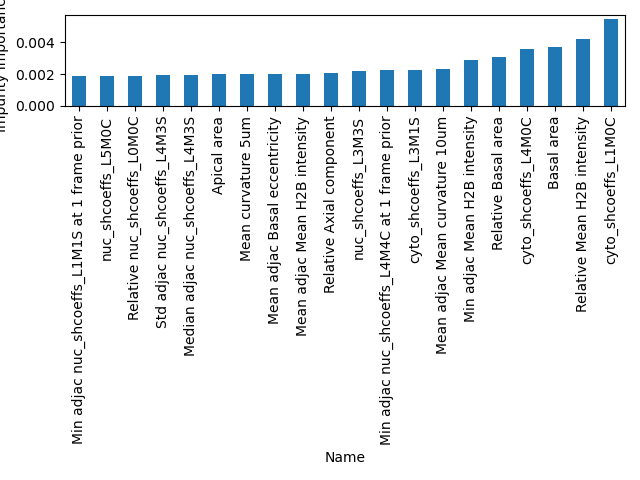

In [51]:
feat_names = division_12h.xs('Measurement',level=1,axis=1).columns
importances = pd.DataFrame(columns = feat_names,index=range(len(models)))
for i,m in enumerate(models):
    importances.loc[i,:] = m[1].feature_importances_

plt.figure()
importances.dropna(how='all').mean(axis=0).sort_values().dropna().tail(20).plot.bar()
plt.tight_layout()
plt.ylabel('Impurity importance')
plt.show()

Text(0.5, 0, 'AUCs')

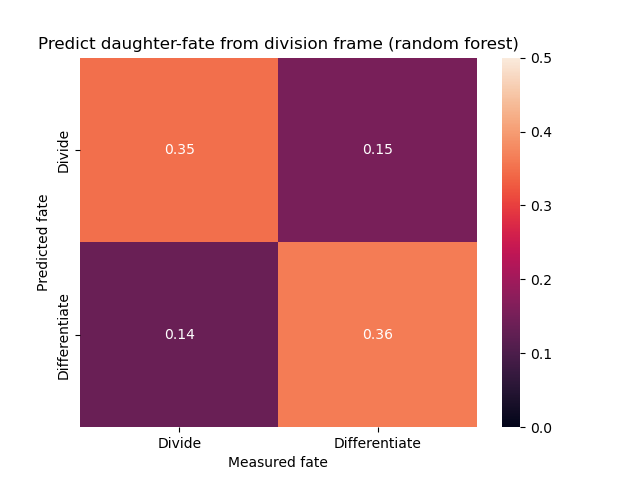

In [ ]:
# Calculate the confusion matrix
avg_confusion = np.array([metrics.confusion_matrix(a,b)/len(a) for a,b in zip(predictions[0,:],predictions[1,:])])

plt.figure()
plt.title('Predict daughter-fate from division frame (random forest)')
sb.heatmap(avg_confusion.mean(axis=0),annot=True,vmin=0,vmax=0.5)
plt.gca().set_xticks([0.5,1.5],labels=['Divide','Differentiate'])
plt.gca().set_yticks([0.5,1.5],labels=['Divide','Differentiate'])
plt.xlabel('Measured fate')
plt.ylabel('Predicted fate')

# Calculate AUC scores
AUCs = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])
plt.figure()
plt.title('Predict daughter-fate from division frame (random forest)')
sb.histplot(AUCs)
plt.xlabel('AUCs')


### Feature selection

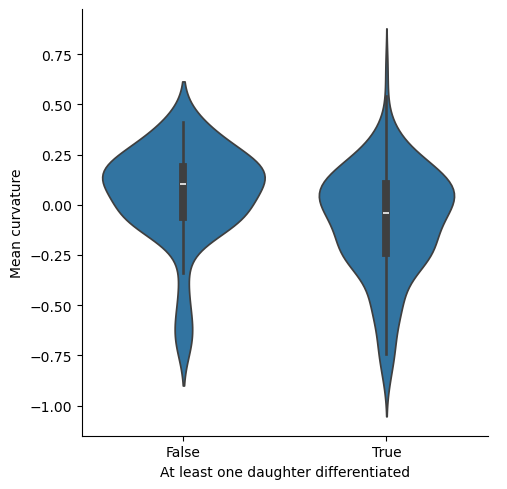

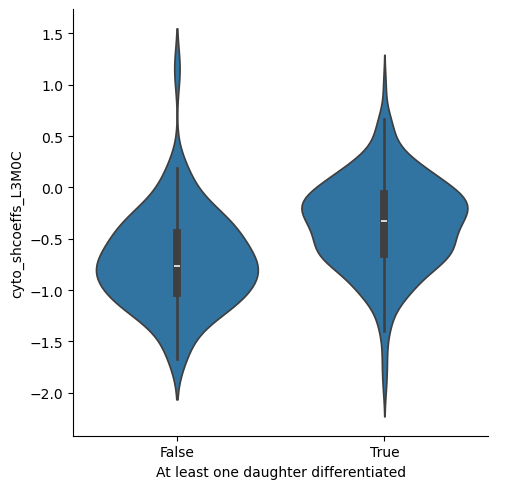

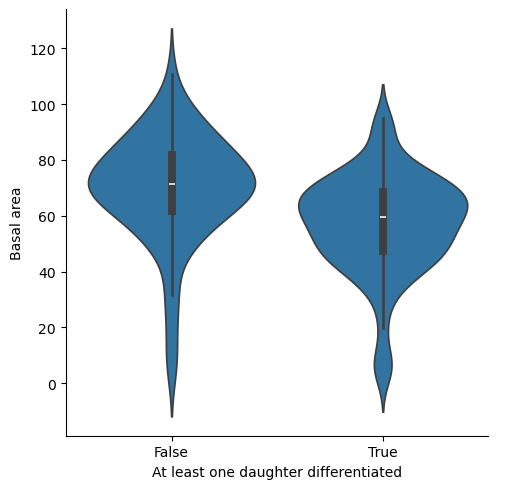

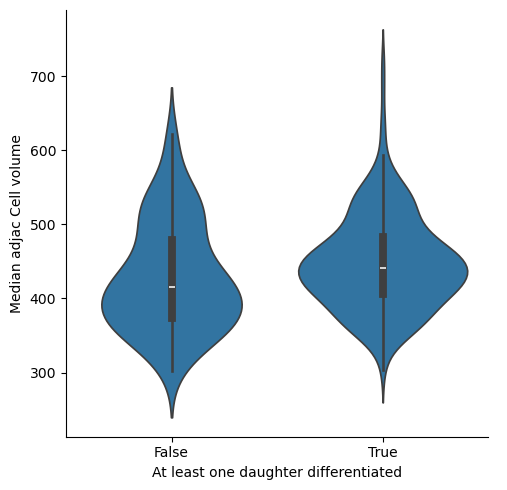

In [22]:
sb.catplot(divisions.droplevel(axis=1,level=1),x=feature2predict,y='Mean curvature',kind='violin')
sb.catplot(divisions.droplevel(axis=1,level=1),x=feature2predict,y='cyto_shcoeffs_L3M0C',kind='violin')
sb.catplot(divisions.droplevel(axis=1,level=1),x=feature2predict,y='Basal area',kind='violin')
sb.catplot(divisions.droplevel(axis=1,level=1),x=feature2predict,y='Median adjac Cell volume',kind='violin')

### RFE

In [23]:
from sklearn import feature_selection

X = divisions.xs('Measurement',level=1,axis=1)
y = divisions[feature2predict,'Meta'].astype(bool)
m = ensemble.RandomForestClassifier().fit(X,y)

results = feature_selection.RFECV(m).fit(X,y)

<ErrorbarContainer object of 3 artists>

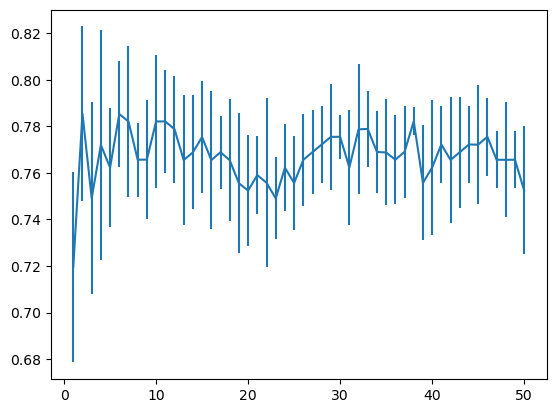

In [24]:
plt.errorbar(x=results.cv_results_['n_features'][:50],
        y=results.cv_results_['mean_test_score'][:50],
        yerr=results.cv_results_['std_test_score'][:50])


In [25]:
print(f'# optimal features: {results.n_features_}')

selected = X.columns[ results.ranking_ == 1]
print(selected)

# optimal features: 2
Index(['cyto_shcoeffs_L3M0C', 'Relative Height to BM'], dtype='object', name='Name')


## 2. ExtraTreesClassifier

In [143]:
# Run classifier
# axis0: observation axis1: prediction

predictions,models = predict_feature(divisions, ensemble.ExtraTreesClassifier(), feature2predict,Niter=1000)


100%|███████████████████████████████████████| 1000/1000 [00:51<00:00, 19.46it/s]


Text(0.5, 0, 'AUCs')

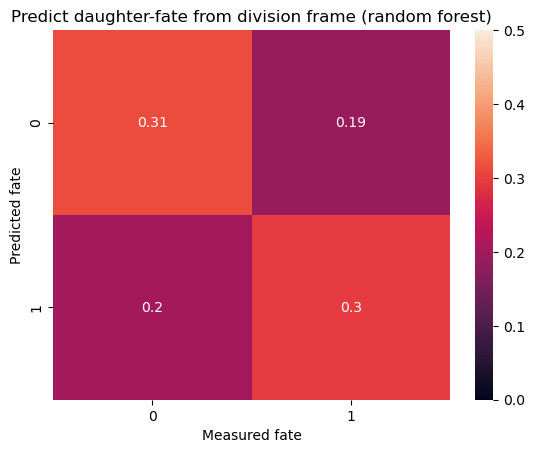

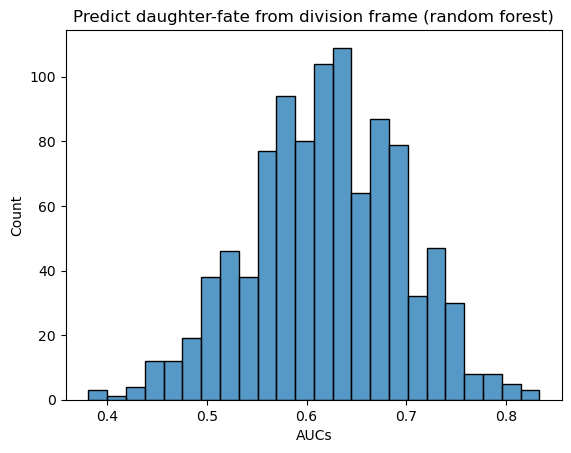

In [144]:
# Calculate the confusion matrix
avg_confusion = np.array([metrics.confusion_matrix(a,b)/len(a) for a,b in zip(predictions[0,:],predictions[1,:])])

plt.title('Predict daughter-fate from division frame (random forest)')
sb.heatmap(avg_confusion.mean(axis=0),annot=True,vmin=0,vmax=0.5)
# plt.gca().set_xticks([0.5,1.5],labels=['Divide','Differentiate'])
# plt.gca().set_yticks([0.5,1.5],labels=['Divide','Differentiate'])
plt.xlabel('Measured fate')
plt.ylabel('Predicted fate')

# Calculate AUC scores
AUCs = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])
plt.figure()
plt.title('Predict daughter-fate from division frame (random forest)')
sb.histplot(AUCs)
plt.xlabel('AUCs')


Text(0, 0.5, 'Impurity importance')

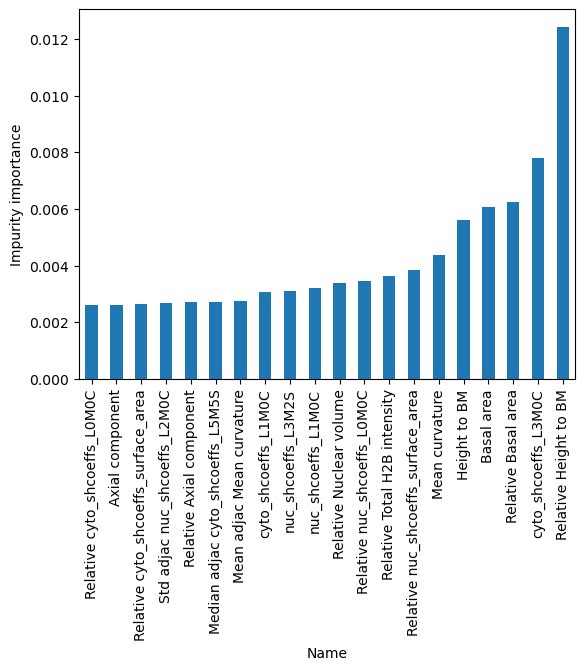

In [145]:
feat_names = divisions.xs('Measurement',level=1,axis=1).columns
importances = pd.DataFrame(columns = feat_names,index=range(len(models)))
for i,m in enumerate(models):
    importances.loc[i,feat_names[m[1].get_support()]] = m[2].feature_importances_

importances.dropna(how='all').mean(axis=0).sort_values().dropna().tail(20).plot.bar()

plt.ylabel('Impurity importance')

In [146]:
from sklearn import feature_selection

X = divisions.xs('Measurement',level=1,axis=1)
y = divisions[feature2predict,'Meta'].astype(bool)
m = ensemble.ExtraTreesClassifier().fit(X,y)

results = feature_selection.RFECV(m).fit(X,y)

# optimal features: 9
Index(['Basal area', 'Height to BM', 'cyto_shcoeffs_L3M0C',
       'nuc_shcoeffs_L3M2S', 'Median adjac nuc_shcoeffs_L5M2S',
       'Min adjac Planar component 1', 'Relative Total H2B intensity',
       'Relative Basal area', 'Relative Height to BM'],
      dtype='object', name='Name')


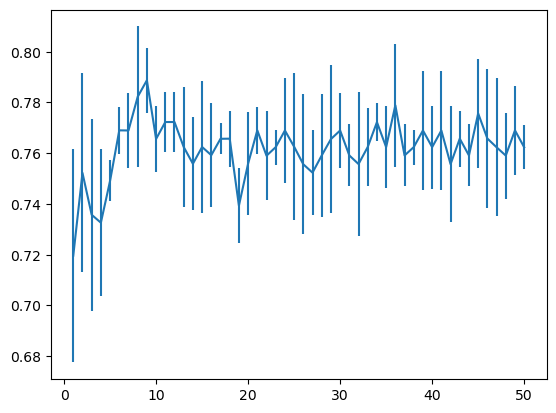

In [148]:
plt.errorbar(x=results.cv_results_['n_features'][:50],
        y=results.cv_results_['mean_test_score'][:50],
        yerr=results.cv_results_['std_test_score'][:50])

print(f'# optimal features: {results.n_features_}')

selected = X.columns[ results.ranking_ == 1]
print(selected)


In [21]:
results.ranking_[X.columns == 'Mean curvature']

array([1])

## Misc: visualizations

/opt/miniconda3/envs/python39/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 8.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


/opt/miniconda3/envs/python39/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 8.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


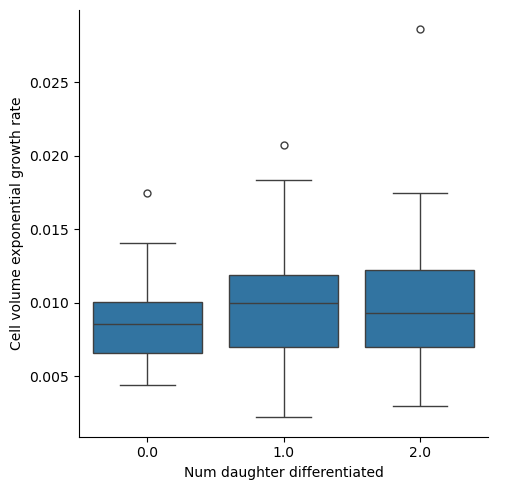

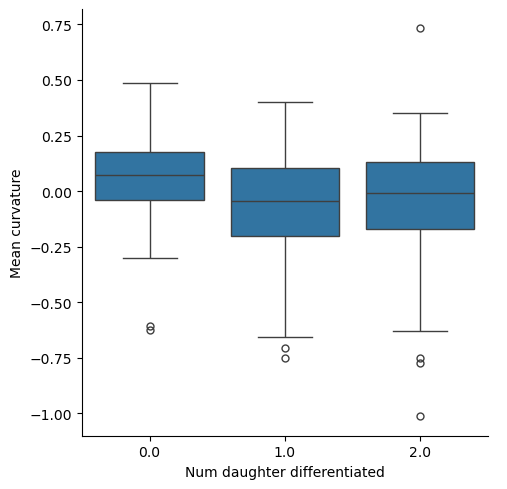

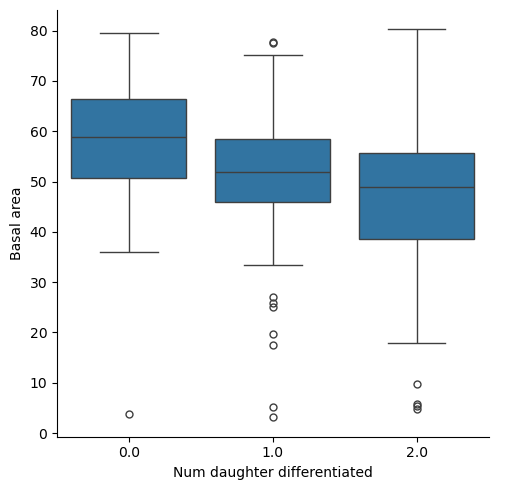

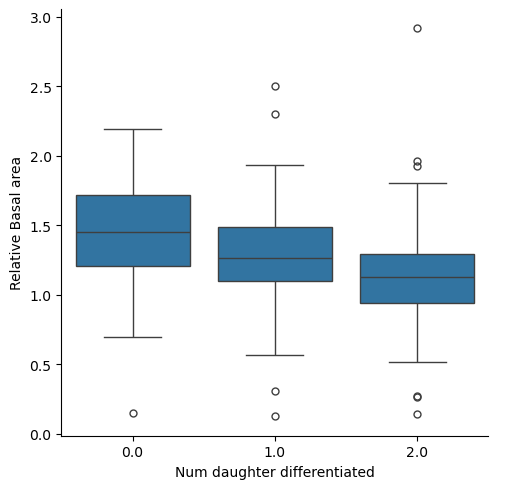

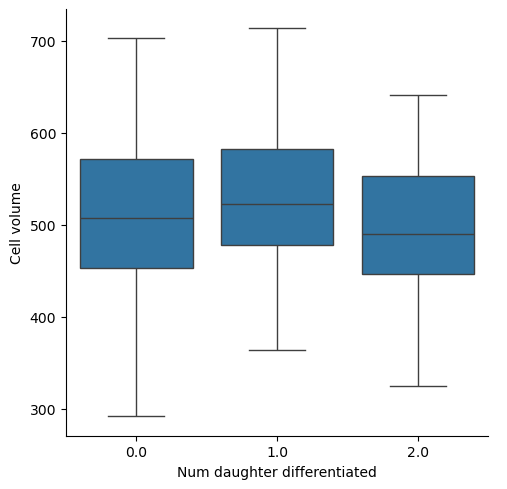

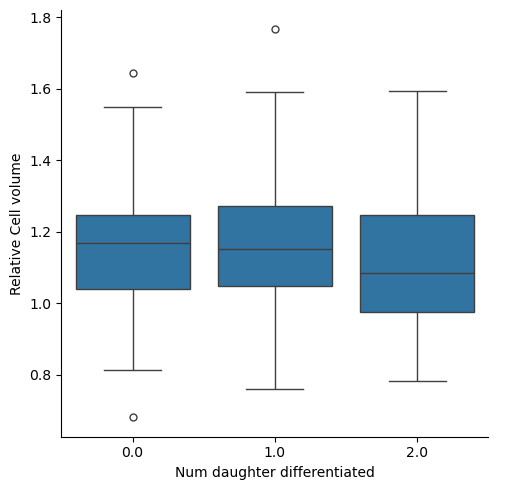

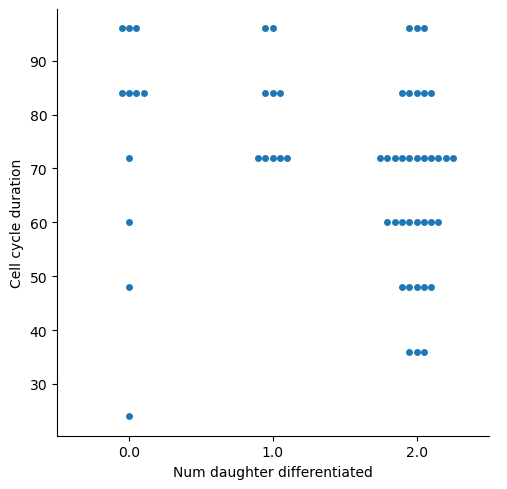

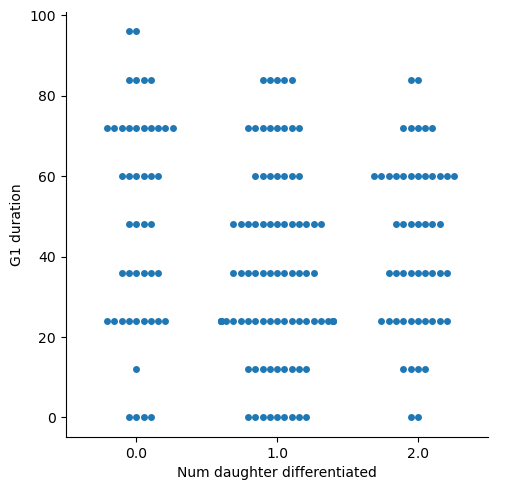

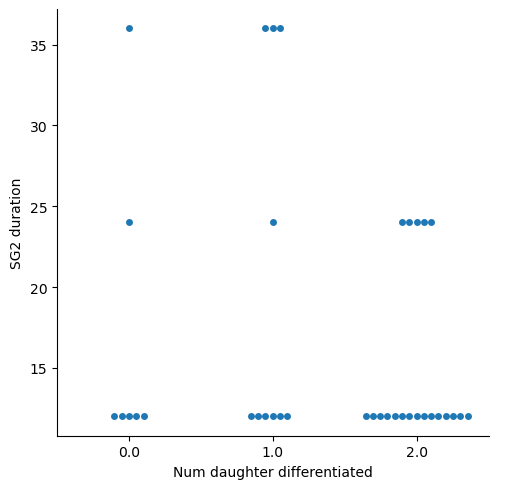

In [19]:
dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
divisions_12h = pd.read_pickle(path.join(dataset_dir,f'divisions_12h.pkl'))

sb.catplot(divisions_12h.droplevel(axis=1,level=1),x='Num daughter differentiated',y='Cell volume exponential growth rate',kind='box')
sb.catplot(divisions_12h.droplevel(axis=1,level=1),x='Num daughter differentiated',y='Mean curvature',kind='box')
sb.catplot(divisions_12h.droplevel(axis=1,level=1),x='Num daughter differentiated',y='Basal area',kind='box')
sb.catplot(divisions_12h.droplevel(axis=1,level=1),x='Num daughter differentiated',y='Relative Basal area',kind='box')
sb.catplot(divisions_12h.droplevel(axis=1,level=1),x='Num daughter differentiated',y='Cell volume',kind='box')
sb.catplot(divisions_12h.droplevel(axis=1,level=1),x='Num daughter differentiated',y='Relative Cell volume',kind='box')
sb.catplot(divisions_12h.droplevel(axis=1,level=1),x='Num daughter differentiated',y='Cell cycle duration',kind='swarm')
sb.catplot(divisions_12h.droplevel(axis=1,level=1),x='Num daughter differentiated',y='G1 duration',kind='swarm')
sb.catplot(divisions_12h.droplevel(axis=1,level=1),x='Num daughter differentiated',y='SG2 duration',kind='swarm')